In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.65
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:


import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K


In [3]:

"""
基本設定
"""
n=210527 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 #288個一組 (24小時一組)
currencynum=5
currency = ["BTC","DASH","ETH","LTC","XMR"]
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
#month = [0,10,20,30,40,50]
month2 = [397,425,456,486,517,547,578,609,639,670,700,731] #2017 365天
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=1



In [4]:

# 控制要不要存檔，1 : Yes, 0 : No
save = 1
epochs = 200
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出
btc = 423.51
DASH = 0.00778 * btc
ETH = 0.0021652 * btc
LTC = 0.00805792 * btc
XMR = 0.00105001 * btc

In [5]:

"""
 V
"""
"""
diff
"""
df = pd.read_csv('btc_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
btc5months = np.zeros(n)
for i in range(n):
    btc5months[i] = df[0][i]
df = pd.read_csv('DASH_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
dash5months = np.zeros(n)
for i in range(n):
    dash5months[i] = df[0][i]
df = pd.read_csv('ETH_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
eth5months = np.zeros(n)
for i in range(n):
    eth5months[i] = df[0][i]
df = pd.read_csv('LTC_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
ltc5months = np.zeros(n)
for i in range(n):
    ltc5months[i] = df[0][i]
df = pd.read_csv('XMR_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
xmr5months = np.zeros(n)
for i in range(n):
    xmr5months[i] = df[0][i]    
print('finish dataread')
Train_data=np.zeros(((n-l+1,len(currency),l)))
for p in range(n-l+1):
    Train_data[p,0,:]=btc5months[p:p+l]
    Train_data[p,1,:]=dash5months[p:p+l]
    Train_data[p,2,:]=eth5months[p:p+l]
    Train_data[p,3,:]=ltc5months[p:p+l]
    Train_data[p,4,:]=xmr5months[p:p+l]

    


(210527, 1)
(210527, 1)
(210527, 1)
(210527, 1)
(210527, 1)
finish dataread


In [6]:
   

"""""""""
str, onehotcode, company code轉換
"""""""""


currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)



In [7]:

"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, condition,typeq):
    # set condition
    def rise_of_fall():
        tmp = np.eye((2))
        d = {0:tmp[0],1:tmp[1]}        
        return d
    # 拼接問題
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)], rise_of_fall()[condition]))

qtype = ['big','small']
HVqtype = ['big','small']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((5,1))
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])/(btc + np.sum(btc5months[:n]))
    outcome[1]=(data2_sum[1])/(DASH + np.sum(dash5months[:n]))
    outcome[2]=(data2_sum[2])/(ETH + np.sum(eth5months[:n]))
    outcome[3]=(data2_sum[3])/(LTC + np.sum(ltc5months[:n]))
    outcome[4]=(data2_sum[4])/(XMR + np.sum(xmr5months[:n]))

    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
            
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i, all_question[0][0]))
        q_pair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #同漲
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_pair[i] = tmp_a
        
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((5,1))
    #data_std=np.std(data,axis=1)
    data2_std=np.std(data2,axis=1)    
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
     
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
        
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i,all_question[1][0]))
        q_HVpair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #前者大
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_HVpair[i] = tmp_a
        
    return (data, q_HVpair, a_HVpair)


In [8]:

"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = BatchNormalization()(model)
        return model
    return conv

def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y

def build_tag(conv):
    d = K.int_shape(conv)[1]
    tag = np.zeros((d,1))
    for i in range(d):
        tag[i] = float(int(i%d))/(d-1)*2-1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)


In [9]:

"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(m1*288,m3*288-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)*288-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)*288-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)*288-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    
    """
    算benchmark
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("benchacc:")
    print(benchacc)
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    

In [10]:

lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []

train_length=3
test_length=1

(None, 24, 1)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=3789 MiB, count=2, average=1894 MiB
[Training model......]
Train on 2067840 samples, validate on 685440 samples
Epoch 1/300
2067840/2067840 [==============================] - 1706s 825us/step - loss: 2.6912 - acc: 0.5103 - val_loss: 0.6958 - val_acc: 0.5253
Epoch 2/300
2067840/2067840 [==============================] - 254s 123us/step - loss: 0.6882 - acc: 0.5564 - val_loss: 0.6739 - val_acc: 0.5592
Epoch 3/300
2067840/2067840 [==============================] - 254s 123us/step - loss: 0.6531 - acc: 0.6085 - val_loss: 0.6549 - val_acc: 0.5961
Epoch 4/300
2067840/2067840 [==============================] - 255s 123us/step - loss: 0.6182 - acc: 0.6488 - val_loss: 0.6167 - val_acc: 0.6586
Epoch 5/300
2067840/2067840 [==============================] - 256s 124us/step - loss: 0.5738 - acc: 0.6779 - val_loss: 0.5482 - val_acc: 0.6989
Epoch 6/300
2067840/2067840 [=

2067840/2067840 [==============================] - 257s 124us/step - loss: 0.4017 - acc: 0.7314 - val_loss: 0.4758 - val_acc: 0.7191
Epoch 112/300
2067840/2067840 [==============================] - 257s 124us/step - loss: 0.4016 - acc: 0.7317 - val_loss: 0.4758 - val_acc: 0.7198
Epoch 113/300
2067840/2067840 [==============================] - 257s 124us/step - loss: 0.4013 - acc: 0.7324 - val_loss: 0.4767 - val_acc: 0.7195
Epoch 114/300
2067840/2067840 [==============================] - 257s 124us/step - loss: 0.4013 - acc: 0.7316 - val_loss: 0.4778 - val_acc: 0.7197
Epoch 115/300
2067840/2067840 [==============================] - 257s 124us/step - loss: 0.4010 - acc: 0.7317 - val_loss: 0.4780 - val_acc: 0.7202
Epoch 116/300
2067840/2067840 [==============================] - 257s 124us/step - loss: 0.4009 - acc: 0.7325 - val_loss: 0.4788 - val_acc: 0.7197
Epoch 117/300
2067840/2067840 [==============================] - 257s 124us/step - loss: 0.4006 - acc: 0.7322 - val_loss: 0.4801 - v

Epoch 167/300
2067840/2067840 [==============================] - 255s 124us/step - loss: 0.3915 - acc: 0.7361 - val_loss: 0.5508 - val_acc: 0.7212
Epoch 168/300
2067840/2067840 [==============================] - 255s 124us/step - loss: 0.3914 - acc: 0.7362 - val_loss: 0.5518 - val_acc: 0.7210
Epoch 169/300
2067840/2067840 [==============================] - 255s 124us/step - loss: 0.3912 - acc: 0.7367 - val_loss: 0.5533 - val_acc: 0.7209
Epoch 170/300
2067840/2067840 [==============================] - 255s 123us/step - loss: 0.3911 - acc: 0.7366 - val_loss: 0.5558 - val_acc: 0.7209
Epoch 171/300
2067840/2067840 [==============================] - 255s 123us/step - loss: 0.3908 - acc: 0.7368 - val_loss: 0.5570 - val_acc: 0.7210
Epoch 172/300
2067840/2067840 [==============================] - 255s 123us/step - loss: 0.3907 - acc: 0.7368 - val_loss: 0.5576 - val_acc: 0.7208
Epoch 173/300
2067840/2067840 [==============================] - 255s 123us/step - loss: 0.3906 - acc: 0.7368 - val_lo

Epoch 223/300
2067840/2067840 [==============================] - 254s 123us/step - loss: 0.3819 - acc: 0.7398 - val_loss: 0.6235 - val_acc: 0.7189
Epoch 224/300
2067840/2067840 [==============================] - 254s 123us/step - loss: 0.3818 - acc: 0.7406 - val_loss: 0.6254 - val_acc: 0.7194
Epoch 225/300
2067840/2067840 [==============================] - 254s 123us/step - loss: 0.3814 - acc: 0.7403 - val_loss: 0.6285 - val_acc: 0.7196
Epoch 226/300
2067840/2067840 [==============================] - 254s 123us/step - loss: 0.3814 - acc: 0.7409 - val_loss: 0.6338 - val_acc: 0.7197
Epoch 227/300
2067840/2067840 [==============================] - 254s 123us/step - loss: 0.3814 - acc: 0.7408 - val_loss: 0.6283 - val_acc: 0.7198
Epoch 228/300
2067840/2067840 [==============================] - 254s 123us/step - loss: 0.3811 - acc: 0.7405 - val_loss: 0.6317 - val_acc: 0.7192
Epoch 229/300
2067840/2067840 [==============================] - 254s 123us/step - loss: 0.3809 - acc: 0.7414 - val_lo

Epoch 279/300
2067840/2067840 [==============================] - 253s 122us/step - loss: 0.3740 - acc: 0.7441 - val_loss: 0.6934 - val_acc: 0.7162
Epoch 280/300
2067840/2067840 [==============================] - 253s 122us/step - loss: 0.3738 - acc: 0.7441 - val_loss: 0.6969 - val_acc: 0.7191
Epoch 281/300
2067840/2067840 [==============================] - 253s 122us/step - loss: 0.3736 - acc: 0.7446 - val_loss: 0.6949 - val_acc: 0.7191
Epoch 282/300
2067840/2067840 [==============================] - 253s 122us/step - loss: 0.3735 - acc: 0.7443 - val_loss: 0.7012 - val_acc: 0.7190
Epoch 283/300
2067840/2067840 [==============================] - 253s 122us/step - loss: 0.3734 - acc: 0.7444 - val_loss: 0.6984 - val_acc: 0.7170
Epoch 284/300
2067840/2067840 [==============================] - 253s 122us/step - loss: 0.3733 - acc: 0.7448 - val_loss: 0.7023 - val_acc: 0.7165
Epoch 285/300
2067840/2067840 [==============================] - 253s 122us/step - loss: 0.3732 - acc: 0.7445 - val_lo

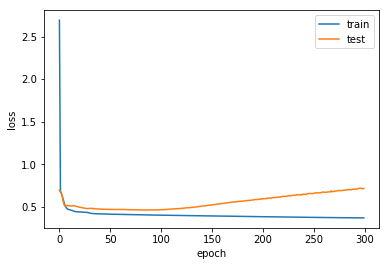

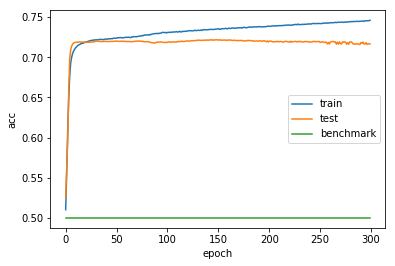

(None, 24, 1)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=3789 MiB, count=1206, average=3217 KiB
[Training model......]
Train on 2044800 samples, validate on 708480 samples
Epoch 1/300
2044800/2044800 [==============================] - 1514s 740us/step - loss: 2.7365 - acc: 0.5047 - val_loss: 1.0171 - val_acc: 0.5041
Epoch 2/300
2044800/2044800 [==============================] - 255s 125us/step - loss: 0.7116 - acc: 0.5112 - val_loss: 1.0316 - val_acc: 0.5029
Epoch 3/300
2044800/2044800 [==============================] - 253s 124us/step - loss: 0.6875 - acc: 0.5232 - val_loss: 0.9739 - val_acc: 0.5144
Epoch 4/300
2044800/2044800 [==============================] - 254s 124us/step - loss: 0.6583 - acc: 0.5704 - val_loss: 1.0372 - val_acc: 0.5366
Epoch 5/300
2044800/2044800 [==============================] - 255s 125us/step - loss: 0.5864 - acc: 0.6401 - val_loss: 0.9394 - val_acc: 0.5804
Epoch 6/300
2044800/2044800

2044800/2044800 [==============================] - 255s 125us/step - loss: 0.4034 - acc: 0.7270 - val_loss: 0.7814 - val_acc: 0.6652
Epoch 112/300
2044800/2044800 [==============================] - 255s 125us/step - loss: 0.4033 - acc: 0.7269 - val_loss: 0.7979 - val_acc: 0.6639
Epoch 113/300
2044800/2044800 [==============================] - 255s 125us/step - loss: 0.4028 - acc: 0.7273 - val_loss: 0.8133 - val_acc: 0.6612
Epoch 114/300
2044800/2044800 [==============================] - 255s 125us/step - loss: 0.4025 - acc: 0.7272 - val_loss: 0.8150 - val_acc: 0.6634
Epoch 115/300
2044800/2044800 [==============================] - 255s 124us/step - loss: 0.4023 - acc: 0.7274 - val_loss: 0.8155 - val_acc: 0.6634
Epoch 116/300
2044800/2044800 [==============================] - 254s 124us/step - loss: 0.4019 - acc: 0.7271 - val_loss: 0.8448 - val_acc: 0.6599
Epoch 117/300
2044800/2044800 [==============================] - 254s 124us/step - loss: 0.4015 - acc: 0.7274 - val_loss: 0.8549 - v

Epoch 167/300
2044800/2044800 [==============================] - 253s 124us/step - loss: 0.3868 - acc: 0.7327 - val_loss: 1.2141 - val_acc: 0.6708
Epoch 168/300
2044800/2044800 [==============================] - 253s 124us/step - loss: 0.3866 - acc: 0.7331 - val_loss: 1.2283 - val_acc: 0.6690
Epoch 169/300
2044800/2044800 [==============================] - 253s 124us/step - loss: 0.3864 - acc: 0.7330 - val_loss: 1.2310 - val_acc: 0.6690
Epoch 170/300
2044800/2044800 [==============================] - 253s 124us/step - loss: 0.3861 - acc: 0.7330 - val_loss: 1.2511 - val_acc: 0.6674
Epoch 171/300
2044800/2044800 [==============================] - 253s 124us/step - loss: 0.3859 - acc: 0.7334 - val_loss: 1.2404 - val_acc: 0.6701
Epoch 172/300
2044800/2044800 [==============================] - 253s 123us/step - loss: 0.3857 - acc: 0.7338 - val_loss: 1.2474 - val_acc: 0.6697
Epoch 173/300
2044800/2044800 [==============================] - 253s 123us/step - loss: 0.3855 - acc: 0.7334 - val_lo

Epoch 223/300
2044800/2044800 [==============================] - 251s 123us/step - loss: 0.3751 - acc: 0.7381 - val_loss: 1.3856 - val_acc: 0.6688
Epoch 224/300
2044800/2044800 [==============================] - 251s 123us/step - loss: 0.3750 - acc: 0.7379 - val_loss: 1.3789 - val_acc: 0.6711
Epoch 225/300
2044800/2044800 [==============================] - 251s 123us/step - loss: 0.3748 - acc: 0.7381 - val_loss: 1.3823 - val_acc: 0.6690
Epoch 226/300
2044800/2044800 [==============================] - 251s 123us/step - loss: 0.3746 - acc: 0.7382 - val_loss: 1.3972 - val_acc: 0.6689
Epoch 227/300
2044800/2044800 [==============================] - 251s 123us/step - loss: 0.3747 - acc: 0.7380 - val_loss: 1.3955 - val_acc: 0.6681
Epoch 228/300
2044800/2044800 [==============================] - 251s 123us/step - loss: 0.3745 - acc: 0.7385 - val_loss: 1.3943 - val_acc: 0.6688
Epoch 229/300
2044800/2044800 [==============================] - 251s 123us/step - loss: 0.3743 - acc: 0.7386 - val_lo

Epoch 279/300
2044800/2044800 [==============================] - 250s 122us/step - loss: 0.3687 - acc: 0.7414 - val_loss: 1.4625 - val_acc: 0.6713
Epoch 280/300
2044800/2044800 [==============================] - 249s 122us/step - loss: 0.3684 - acc: 0.7415 - val_loss: 1.4649 - val_acc: 0.6718
Epoch 281/300
2044800/2044800 [==============================] - 249s 122us/step - loss: 0.3683 - acc: 0.7420 - val_loss: 1.4579 - val_acc: 0.6730
Epoch 282/300
2044800/2044800 [==============================] - 249s 122us/step - loss: 0.3683 - acc: 0.7419 - val_loss: 1.4781 - val_acc: 0.6702
Epoch 283/300
2044800/2044800 [==============================] - 249s 122us/step - loss: 0.3683 - acc: 0.7415 - val_loss: 1.4822 - val_acc: 0.6697
Epoch 284/300
2044800/2044800 [==============================] - 249s 122us/step - loss: 0.3680 - acc: 0.7421 - val_loss: 1.4745 - val_acc: 0.6709
Epoch 285/300
2044800/2044800 [==============================] - 249s 122us/step - loss: 0.3679 - acc: 0.7419 - val_lo

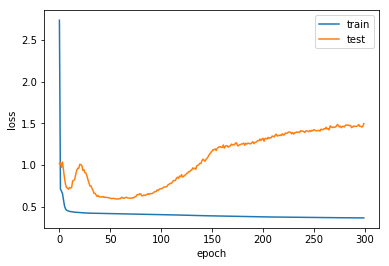

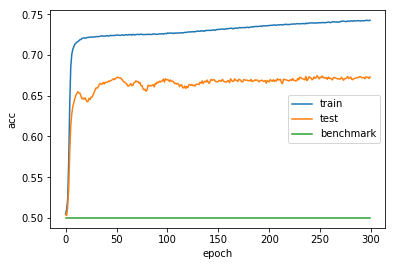

(None, 24, 1)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=7641 MiB, count=1209, average=6472 KiB
[Training model......]
Train on 2113920 samples, validate on 685440 samples
Epoch 1/300
2113920/2113920 [==============================] - 1692s 800us/step - loss: 2.9046 - acc: 0.5075 - val_loss: 0.6951 - val_acc: 0.5387
Epoch 2/300
2113920/2113920 [==============================] - 260s 123us/step - loss: 0.7036 - acc: 0.5259 - val_loss: 0.6682 - val_acc: 0.5672
Epoch 3/300
2113920/2113920 [==============================] - 259s 123us/step - loss: 0.6675 - acc: 0.5658 - val_loss: 0.6326 - val_acc: 0.6073
Epoch 4/300
2113920/2113920 [==============================] - 260s 123us/step - loss: 0.6287 - acc: 0.6121 - val_loss: 0.5713 - val_acc: 0.6690
Epoch 5/300
2113920/2113920 [==============================] - 261s 124us/step - loss: 0.5712 - acc: 0.6590 - val_loss: 0.4924 - val_acc: 0.6956
Epoch 6/300
2113920/2113920

2113920/2113920 [==============================] - 259s 123us/step - loss: 0.4145 - acc: 0.7172 - val_loss: 0.4407 - val_acc: 0.6973
Epoch 112/300
2113920/2113920 [==============================] - 259s 123us/step - loss: 0.4142 - acc: 0.7173 - val_loss: 0.4398 - val_acc: 0.6980
Epoch 113/300
2113920/2113920 [==============================] - 259s 123us/step - loss: 0.4139 - acc: 0.7171 - val_loss: 0.4400 - val_acc: 0.6983
Epoch 114/300
2113920/2113920 [==============================] - 259s 123us/step - loss: 0.4139 - acc: 0.7173 - val_loss: 0.4391 - val_acc: 0.6990
Epoch 115/300
2113920/2113920 [==============================] - 259s 123us/step - loss: 0.4137 - acc: 0.7172 - val_loss: 0.4389 - val_acc: 0.6997
Epoch 116/300
2113920/2113920 [==============================] - 259s 123us/step - loss: 0.4136 - acc: 0.7165 - val_loss: 0.4400 - val_acc: 0.6995
Epoch 117/300
2113920/2113920 [==============================] - 259s 123us/step - loss: 0.4132 - acc: 0.7172 - val_loss: 0.4405 - v

Epoch 167/300
2113920/2113920 [==============================] - 257s 122us/step - loss: 0.4031 - acc: 0.7200 - val_loss: 0.4651 - val_acc: 0.7060
Epoch 168/300
2113920/2113920 [==============================] - 257s 122us/step - loss: 0.4029 - acc: 0.7202 - val_loss: 0.4673 - val_acc: 0.7075
Epoch 169/300
2113920/2113920 [==============================] - 257s 122us/step - loss: 0.4032 - acc: 0.7201 - val_loss: 0.4671 - val_acc: 0.7076
Epoch 170/300
2113920/2113920 [==============================] - 257s 122us/step - loss: 0.4028 - acc: 0.7205 - val_loss: 0.4634 - val_acc: 0.7084
Epoch 171/300
2113920/2113920 [==============================] - 257s 122us/step - loss: 0.4027 - acc: 0.7201 - val_loss: 0.4653 - val_acc: 0.7089
Epoch 172/300
2113920/2113920 [==============================] - 257s 122us/step - loss: 0.4028 - acc: 0.7195 - val_loss: 0.4653 - val_acc: 0.7088
Epoch 173/300
2113920/2113920 [==============================] - 257s 122us/step - loss: 0.4025 - acc: 0.7195 - val_lo

Epoch 223/300
2113920/2113920 [==============================] - 255s 121us/step - loss: 0.3949 - acc: 0.7227 - val_loss: 0.5123 - val_acc: 0.7119
Epoch 224/300
2113920/2113920 [==============================] - 255s 121us/step - loss: 0.3948 - acc: 0.7227 - val_loss: 0.5144 - val_acc: 0.7108
Epoch 225/300
2113920/2113920 [==============================] - 255s 121us/step - loss: 0.3946 - acc: 0.7229 - val_loss: 0.5050 - val_acc: 0.7118
Epoch 226/300
2113920/2113920 [==============================] - 255s 121us/step - loss: 0.3946 - acc: 0.7231 - val_loss: 0.5105 - val_acc: 0.7110
Epoch 227/300
2113920/2113920 [==============================] - 255s 121us/step - loss: 0.3944 - acc: 0.7228 - val_loss: 0.5077 - val_acc: 0.7118
Epoch 228/300
2113920/2113920 [==============================] - 255s 121us/step - loss: 0.3942 - acc: 0.7231 - val_loss: 0.5119 - val_acc: 0.7120
Epoch 229/300
2113920/2113920 [==============================] - 255s 121us/step - loss: 0.3940 - acc: 0.7234 - val_lo

Epoch 279/300
2113920/2113920 [==============================] - 253s 120us/step - loss: 0.3886 - acc: 0.7257 - val_loss: 0.5566 - val_acc: 0.7102
Epoch 280/300
2113920/2113920 [==============================] - 253s 120us/step - loss: 0.3886 - acc: 0.7254 - val_loss: 0.5583 - val_acc: 0.7108
Epoch 281/300
2113920/2113920 [==============================] - 253s 120us/step - loss: 0.3887 - acc: 0.7252 - val_loss: 0.5572 - val_acc: 0.7108
Epoch 282/300
2113920/2113920 [==============================] - 253s 120us/step - loss: 0.3885 - acc: 0.7256 - val_loss: 0.5773 - val_acc: 0.7099
Epoch 283/300
2113920/2113920 [==============================] - 253s 120us/step - loss: 0.3882 - acc: 0.7256 - val_loss: 0.5739 - val_acc: 0.7092
Epoch 284/300
2113920/2113920 [==============================] - 253s 120us/step - loss: 0.3881 - acc: 0.7249 - val_loss: 0.5747 - val_acc: 0.7092
Epoch 285/300
2113920/2113920 [==============================] - 253s 120us/step - loss: 0.3879 - acc: 0.7259 - val_lo

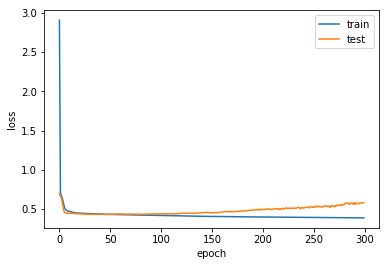

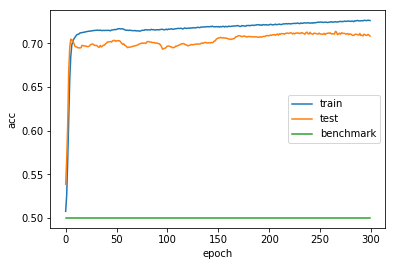

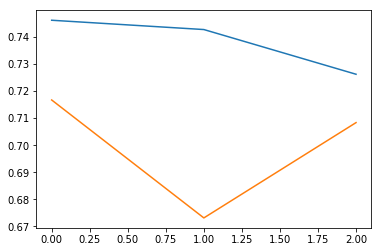

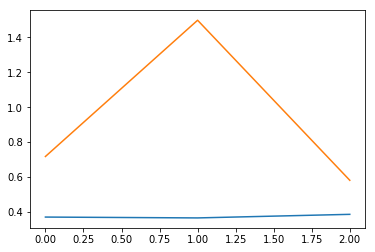

In [11]:
for i in range(12,15,1):

    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((14,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(i)
    fit_show(Train_data,month[i],month[i+3],month[i+4])
    
plt.plot(lastepoch_train_acc)
plt.plot(lastepoch_test_acc)
plt.show()
plt.plot(lastepoch_train_loss)
plt.plot(lastepoch_test_loss)
plt.show()

In [11]:
i=12

In [13]:
MLP_unit=64
visual_scene = Input((l,currencynum))
visual_conv = ConvolutionNetworks(20,5)(visual_scene)
tag = build_tag(visual_conv)
visual_conv = Concatenate()([visual_conv, tag])
shapes = visual_conv.shape
w = shapes[1]
features= []
for k1 in range(w):
    def get_feature(t):
        return t[:, k1, :]
    get_feature_layer = Lambda(get_feature)
    features.append(get_feature_layer(visual_conv))

input2 = Input((14,))
onehot_encode = input2   

relations = []
concat = Concatenate()
for feature1 in features:
    for feature2 in features:
        relations.append(concat([feature1, feature2, onehot_encode]))    


g_MLP = get_MLP(5, get_dense(5,MLP_unit))
f_MLP = get_MLP(5, get_dense(5,MLP_unit))
print("g_MLP")
mid_relations = []
for r in relations:
    mid_relations.append(g_MLP(r))

combined_relation = Add()(mid_relations)

#f_MLP
rn = dropout_dense(combined_relation,MLP_unit)
rn = dropout_dense(rn,MLP_unit)
print('drop_out')

pred = Dense(1, activation = 'sigmoid')(rn)

model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
optimizer = Adam(lr = 3e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print('compile model success')    

#model.summary()
print(i)

(None, 24, 1)
g_MLP
drop_out
compile model success
12


In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 36, 5)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 32, 20)       520         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 28, 20)       2020        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 24, 20)       2020        conv1d_2[0][0]                   
__________________________________________________________________________________________________
batch_norm

dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
                                                                 dense_1[1][0]                    
                                                                 dense_1[2][0]                    
                                                                 dense_1[3][0]                    
                                                                 dense_1[4][0]                    
                                                                 dense_1[5][0]                    
                                                                 dense_1[6][0]                    
                                                                 dense_1[7][0]                    
                                                                 dense_1[8][0]                    
                                                                 dense_1[9][0]                    
          